In [16]:
# Check if package is already installed
if (!requireNamespace("anndataR", quietly = TRUE)) {
  # If not installed, install from GitHub
  if (!requireNamespace("devtools", quietly = TRUE)) {
    install.packages("devtools")  # Install devtools if not already installed
  }
  
  devtools::install_github("scverse/anndataR@220f977", dependencies = TRUE, upgrade = "never")  
}

# Load the package after installation
library(anndataR) # This package need to be loaded first


In [6]:
suppressPackageStartupMessages({
    library(Seurat)
    library(patchwork)
    library(celldex)
    library(SingleR)
    library(ShinyCell)
    library(glmGamPoi)
    library(stringr)
    })

In [14]:
# Read an h5ad file:
adata <- read_h5ad("data/PBMC_Noreg.h5ad", to = "InMemoryAnnData")
obj <- adata$to_Seurat()
obj
save(obj, file = file.path("object", "00.rda"))

An object of class Seurat 
22941 features across 35578 samples within 1 assay 
Active assay: RNA (22941 features, 0 variable features)
 2 layers present: counts, data

In [17]:
obj[["percent.mt"]] <- PercentageFeatureSet(object = obj, pattern = "^MT-")
obj <- subset(obj, subset = nFeature_RNA > 350 & nFeature_RNA < 5000 & percent.mt < 10)
obj
save(obj, file = file.path("object", "01.rda"))

An object of class Seurat 
22941 features across 34144 samples within 1 assay 
Active assay: RNA (22941 features, 0 variable features)
 2 layers present: counts, data

In [ ]:
# Data already normalized
# obj <- SCTransform(obj, ncells = 3000,  variable.features.n = 2000, vst.flavor="v2", method = 'glmGamPoi', conserve.memory = TRUE)
# save(obj, file=file.path("object", "02.rda"))

In [12]:
load(file = file.path("object", "01.rda"))
obj <- FindVariableFeatures(obj) 
obj <- ScaleData(obj)
obj <- RunPCA(obj, npcs = 30, verbose = TRUE)
obj <- RunUMAP(obj, reduction = "pca", dims = 1:20)
obj <- FindNeighbors(obj, reduction = "pca", dims = 1:20)
obj <- FindClusters(obj, resolution = 0.5)
save(obj, file=file.path("object", "03.rda"))

Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in hvf.info$variance.expected[not.const] <- 10^fit$fitted:
“number of items to replace is not a multiple of replacement length”
Centering and scaling data matrix

PC_ 1 
Positive:  RPS12, RPL34, RPL13, RPS14, RPS15A, RPS3, RPS28, RPS23, RPL18A, RPS19 
	   RPL19, RPS3A, RPL10, RPL30, RPL11, RPL26, RPL35A, RPS8, RPS21, RPL36 
	   RPS24, RPL37, GZMK, RPS4X, RPS7, RPS15, TPT1, RPS13, RPL10A, RPL18 
Negative:  ACTB, NKG7, PRF1, SPON2, GZMA, FGFBP2, ITGB2, TMSB10, CST7, MYL12A 
	   CLIC3, FCER1G, GZMM, MYL6, CORO1A, CALR, MYOM2, CLIC1, CCL4, ABI3 
	   HLA-C, HLA-B, CD99, LGALS1, ADGRG1, PPP1CA, EMP3, ARHGDIB, SERF2, RHOC 
PC_ 2 
Positive:  NFKBIA, FOS, JUN, DUSP2, IER2, EIF1, H3F3B, IFRD1, BTG1, ZFP36L2 
	   BTG2, YPEL5, PTMA, PPP1R15A, ZFP36, CD69, PMAIP1, RBM39, FUS, CCNL1 
	   AC020916.1, DDX3X, YBX1, SRSF2, FOSB, SFPQ, MYLIP, SMAD7, SRSF7, SRSF5 
Negative:  PRF1, FGFBP2, HSPA8, NKG7, CST7, CLIC1, CD3E, HLA-B, T

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 34144
Number of edges: 982914

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9070
Number of communities: 10
Elapsed time: 5 seconds


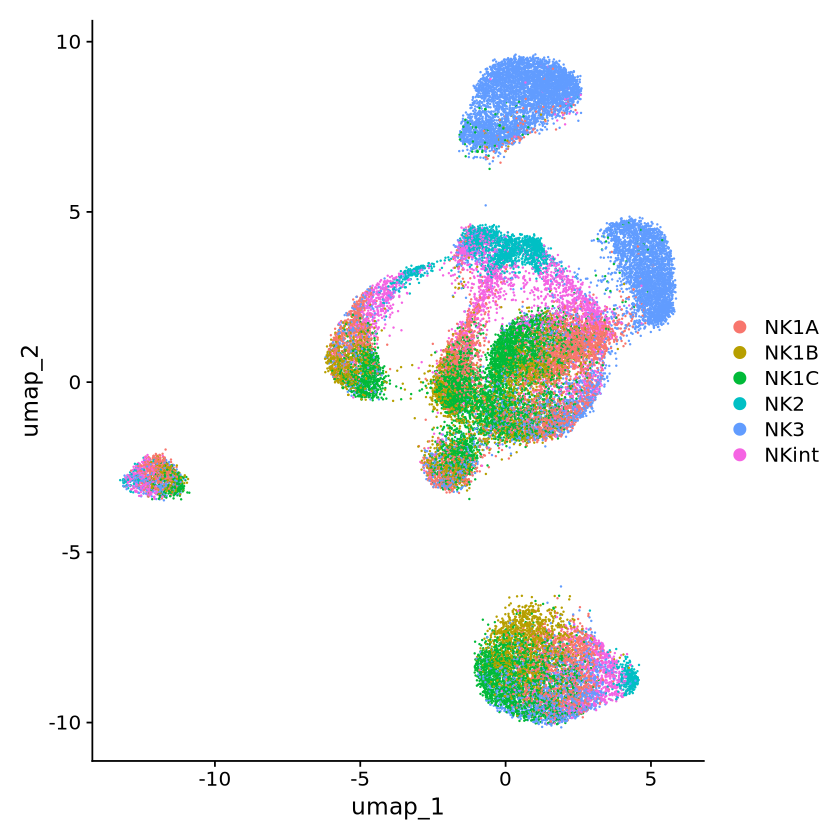

In [13]:
DimPlot(obj)

In [21]:
load( file=file.path("object", "03.rda"))

In [23]:
blueprint.ref <- celldex::BlueprintEncodeData()
sce <- LayerData(obj)
blueprint.main <- SingleR(test = sce, assay.type.test = 1, ref = blueprint.ref, labels = blueprint.ref$label.main)
obj@meta.data$blueprint.main <- blueprint.main$pruned.labels

table(obj@meta.data$blueprint.main)

save(obj, file=file.path("object", "04.rda"))

see ?celldex and browseVignettes('celldex') for documentation

loading from cache

see ?celldex and browseVignettes('celldex') for documentation

loading from cache




     Adipocytes      Astrocytes    Chondrocytes     Macrophages        Myocytes 
           1732               4              10               1             505 
        Neurons     Neutrophils Skeletal muscle   Smooth muscle 
          22422             151            9004              23 

In [19]:
monaco.ref <- celldex::MonacoImmuneData()
sce <- LayerData(obj)
monaco.fine <- SingleR(test = sce, assay.type.test = 1, ref = monaco.ref, labels = monaco.ref$label.fine)
obj@meta.data$monaco.fine <- monaco.fine$pruned.labels

table(obj@meta.data$monaco.fine)

save(obj, file=file.path("object", "05.rda"))

see ?celldex and browseVignettes('celldex') for documentation

loading from cache

see ?celldex and browseVignettes('celldex') for documentation

loading from cache



In [ ]:
obj@meta.data$CellType <- obj@meta.data$ident
obj@meta.data$ident <- NULL

In [24]:
seu =  obj
scConf = createConfig(seu)
makeShinyApp(seu, scConf,
             gene.mapping = TRUE,
             shiny.title = "Human NKs sc-RNAseq",
             shiny.dir = "Blood_NK_scRNA-seq_metaNK/",
             default.multigene = c('LILRB1', 'PDCD1')) 
system("R -e \"shiny::runApp('Blood_NK_scRNA-seq_metaNK')\"")